In [41]:
from skimage.measure import compare_ssim
import argparse
import imutils
import cv2
from matplotlib import pyplot as plt
input_path = '/Users/frodo/Downloads/initial_matlab_deckchair_scripts/ori/night_time/'

# load the two input images
imageA = cv2.imread(input_path + '../Mean.png')
imageB = cv2.imread(input_path + 'N2_0117.png')
# imageA = cv2.imread('/Users/frodo/Desktop/me/without.jpg')
# imageB = cv2.imread('/Users/frodo/Desktop/me/with.jpg')
 
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

# threshold the difference image, followed by finding contours to
# obtain the regions of the two input images that differ
thresh = cv2.threshold(diff, 0, 255,
                       cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour and then draw the
    # bounding box on both input images to represent where the two
    # images differ
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(imageB, (x, y), (x + w, y + h), (0, 0, 255), 2)
 
# show the output images
cv2.imwrite("/Users/frodo/Desktop/Original.png", imageA)
cv2.imwrite("/Users/frodo/Desktop/Modified.png", imageB)
cv2.imwrite("/Users/frodo/Desktop/Difference.png", diff)
cv2.imwrite("/Users/frodo/Desktop/Threshold.png", thresh)

# cv2.imshow("Original", imageA)
# cv2.imshow("Modified", imageB)
# cv2.imshow("Diff", diff)
# cv2.imshow("Thresh", thresh)
# cv2.waitKey(0)

SSIM: 0.557144682367


True

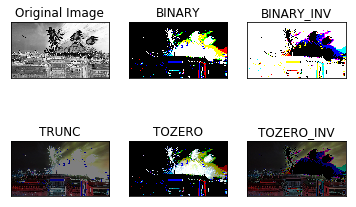

In [42]:
# basic threshold
ret,thresh1 = cv2.threshold(imageB,127,255,cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(imageB,127,255,cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(imageB,127,255,cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(imageB,127,255,cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(imageB,127,255,cv2.THRESH_TOZERO_INV)
titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [diff, thresh1, thresh2, thresh3, thresh4, thresh5]
for i in xrange(6):
    plt.subplot(2,3,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    plt.savefig('/Users/frodo/Desktop/' + titles[i])
plt.show()

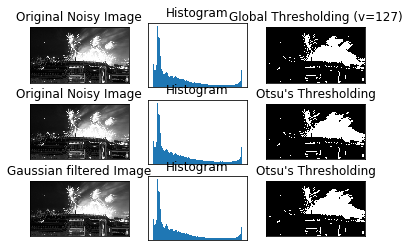

In [44]:
# Otsu’s Binarization

# load the two input images
diff = cv2.imread(input_path + 'N2_0117.png',0)
 
# global thresholding
ret1,th1 = cv2.threshold(diff,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(diff,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(diff,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [diff, 0, th1,
          diff, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in xrange(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.savefig('/Users/frodo/Desktop/thresholds.png')
plt.show()

In [43]:
import numpy as np

(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
blur = cv2.GaussianBlur(diff,(5,5),0)

# find normalized_histogram, and its cumulative distribution function
hist = cv2.calcHist([blur],[0],None,[256],[0,256])

hist_norm = hist.ravel()/hist.max()
Q = hist_norm.cumsum()

bins = np.arange(256)

fn_min = np.inf
thresh = -1

for i in xrange(1,256):
    p1,p2 = np.hsplit(hist_norm,[i]) # probabilities
    q1,q2 = Q[i],Q[255]-Q[i] # cum sum of classes
    b1,b2 = np.hsplit(bins,[i]) # weights

    # finding means and variances
    m1,m2 = np.sum(p1*b1)/q1, np.sum(p2*b2)/q2
    v1,v2 = np.sum(((b1-m1)**2)*p1)/q1,np.sum(((b2-m2)**2)*p2)/q2

    # calculates the minimization function
    fn = v1*q1 + v2*q2
    if fn < fn_min:
        fn_min = fn
        thresh = i

# find otsu's threshold value with OpenCV function
ret, otsu = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print thresh,ret

thresh = cv2.threshold(diff, 0, 255,
                       cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if imutils.is_cv2() else cnts[1]

# loop over the contours
for c in cnts:
    # compute the bounding box of the contour and then draw the
    # bounding box on both input images to represent where the two
    # images differ
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
    cv2.rectangle(imageB, (x, y), (x + w, y + h), (0, 0, 255), 2)
 
# show the output images
cv2.imwrite("/Users/frodo/Desktop/Original.png", imageA)
cv2.imwrite("/Users/frodo/Desktop/Modified.png", imageB)
cv2.imwrite("/Users/frodo/Desktop/Difference.png", diff)
cv2.imwrite("/Users/frodo/Desktop/Threshold.png", thresh)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


157 156.0


True

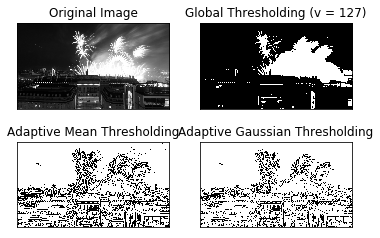

In [47]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread(input_path + 'N2_0117.png',0)
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
for i in xrange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

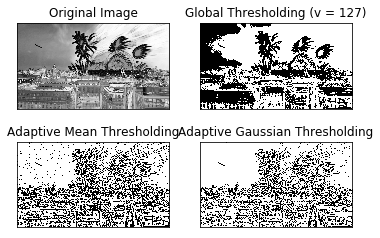

In [10]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from skimage.measure import compare_ssim

input_path = '/Users/frodo/Documents/Placement/data/ori/night_time/'
imageA = cv2.imread(input_path + '../Mean.png')
imageB = cv2.imread(input_path + 'N2_0117.png')
# imageA = cv2.imread('/Users/frodo/Desktop/me/without.jpg')
# imageB = cv2.imread('/Users/frodo/Desktop/me/with.jpg')
 
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")

diff = cv.medianBlur(diff,5)
ret,th1 = cv.threshold(diff,127,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(diff,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(diff,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [diff, th1, th2, th3]
for i in xrange(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

In [11]:
from skimage.measure import compare_ssim
from matplotlib import pyplot as plt
import argparse
import imutils
import cv2

input_path = '/Users/frodo/Documents/Placement/data/ori/night_time/'

# load the two input images
imageA = cv2.imread(input_path + )
imageB = cv2.imread(args["second"])

# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_BGR2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_BGR2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")

# basic threshold
ret,thresh2 = cv2.threshold(diff,127,255,cv2.THRESH_BINARY_INV)
titles = ['BINARY_INV']
images = [thresh]

for i in xrange(1):
    plt.subplot(1,1,1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
    plt.savefig(args["output"] + "features_" + titles[i])

    cnts = cv2.findContours(images[i].copy(), cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
    
    print 'cnts' + cnts
    print 

    cnts = cnts[0] if imutils.is_cv2() else cnts[1]

    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        #cv2.rectangle(imageA, (x, y), (x + w, y + h), (0, 0, 255), 2)
        cv2.rectangle(imageB, (x, y), (x + w, y + h), (0, 0, 255), 2)
        
#     cv2.imwrite(args["output"] + "features_" + titles[i] + ".png", imageB)
#     imageB = cv2.imread(args["second"])


usage: ipykernel_launcher.py [-h] -f FIRST -s SECOND -o OUTPUT
ipykernel_launcher.py: error: argument -s/--second is required


SystemExit: 2

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2886: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
